In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../Jared')
from my_pysyncon import Dataprep_v2, AugSynthGPT
from my_pysyncon.utils import PlaceboTest, date_to_str, winsorize_series_preserve_nans
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from pmdarima import model_selection
import warnings
warnings.filterwarnings('ignore')

This notebook computes the normalized r-squared for the pre-treatment fit for each of our synthetic control models and fits the baseline ARIMA models for each of the models

In [3]:
# import the data
df_mo = pd.read_csv('../../SharedData/total_state_data_orig.csv')

# remove data post-2014-01-01
df = df_mo[df_mo['date'] < '2014-01-01']

In [7]:
# this list is used to make certain columns later
abbreviations = [
    "AL", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

In [8]:
# add a bunch of features (these will eventually get moved to combine_files.ipynb)
df_mo['co2_per_capita'] = (df_mo['monthly_emissions'] / df_mo['monthly_population'])
df_mo['gdp_per_capita'] = df_mo['gdp_rel_2017_interp']*10000 / df_mo['monthly_population']
df_mo['eprod_per_capita'] = (df_mo['monthly_energy_prod'] / df_mo['monthly_population'])
df_mo['eflow_per_capita'] = df_mo['monthly_energy_flow'] / df_mo['monthly_population']
df_mo['euse_per_capita'] = df_mo['monthly_energy_use'] / df_mo['monthly_population']
df_mo['avg_facility_age'] = (df_mo['total_facility_age']/100)/df_mo['monthly_num_plants']
df_mo['avg_weighted_facility_age'] = (df_mo['total_weighted_facility_age'])/(10**7)/df_mo['monthly_num_plants'] 

# winsorize snow, energy use, and renewable energy %
df_mo['snow_wnsr'] = winsorize_series_preserve_nans(df_mo['snow'], limits=[0.00, 0.15])
df_mo['euse_per_capita_wnsr'] = winsorize_series_preserve_nans(df_mo['euse_per_capita'], limits=[0.00, 0.05])
df_mo['monthly_renew_pct_wnsr'] = winsorize_series_preserve_nans(df_mo['monthly_renew_pct'], limits=[0.00, 0.05])

print(df_mo['euse_per_capita'].describe())
print(df_mo['euse_per_capita_wnsr'].describe())
print(df_mo['snow'].describe())
print(df_mo['snow_wnsr'].describe())
print(df_mo['monthly_renew_pct'].describe())
print(df_mo['monthly_renew_pct_wnsr'].describe())

df_mo['monthly_pop_density_log'] = np.log(df_mo['monthly_pop_density'])
df_mo['co2_per_capita_log'] = np.log(df_mo['co2_per_capita'])
df_mo['euse_per_capita_log'] = np.log(df_mo['euse_per_capita'])
df_mo['gdp_per_capita_log'] = np.log(df_mo['gdp_per_capita'])
df_mo['monthly_pop_density_log'] = np.log(df_mo['monthly_pop_density'])
df_mo['snow_wnsr_log'] = np.log1p(df_mo['snow_wnsr'])
df_mo['monthly_renew_pct_wnsr_log'] = np.log1p(df_mo['monthly_renew_pct_wnsr'])

sma_feature_list = ['monthly_pop_density', 'yearly_pop_density',
       'monthly_emissions', 'prcp', 'snow', 'tavg',
       'gdp_rel_2017', 'gdp_rel_2017_interp', 'yearly_gdp_rel_2017',
       'monthly_energy_prod', 'yearly_energy_prod', 'monthly_energy_use',
       'yearly_energy_use', 'monthly_energy_flow', 'yearly_energy_flow',
       'monthly_num_plants', 'yearly_num_plants', 'total_facility_age',
       'monthly_energy_total', 'yearly_energy_total', 'monthly_energy_renew',
       'yearly_energy_renew', 'monthly_renew_pct', 'yearly_renew_pct',
       'monthly_energy_fossil', 'yearly_energy_fossil', 'monthly_fossil_pct',
       'yearly_fossil_pct','monthly_energy_coal', 'yearly_energy_coal', 'monthly_coal_pct',
       'yearly_coal_pct', 'co2_per_capita',
       'gdp_per_capita', 'eprod_per_capita', 'eflow_per_capita',
       'euse_per_capita', 'avg_facility_age', 'total_weighted_facility_age','avg_weighted_facility_age','monthly_pop_density_log','co2_per_capita_log',
       'euse_per_capita_log','gdp_per_capita_log','monthly_pop_density_log','snow_wnsr','snow_wnsr_log','euse_per_capita_wnsr','monthly_renew_pct_wnsr_log']

# create column for simple moving avg of co2_per_capita; ma_window is the moving average window size (n=1 corresponds to usual monthly results)
df_mo['co2_per_capita_sma']= np.nan
ma_window = 6

for feature in sma_feature_list:
    for state in abbreviations:
        df_mo.loc[df_mo.state==state,feature+str('_sma')] = df_mo.loc[df_mo.state==state,feature].rolling(window=ma_window).mean()

count    17040.000000
mean         0.029005
std          0.012053
min          0.013865
25%          0.021356
50%          0.026473
75%          0.032486
max          0.081241
Name: euse_per_capita, dtype: float64
count    17040.000000
mean         0.028088
std          0.008969
min          0.013865
25%          0.021356
50%          0.026473
75%          0.032486
max          0.053809
Name: euse_per_capita_wnsr, dtype: float64
count    17281.000000
mean         2.421307
std          6.816829
min          0.000000
25%          0.000000
50%          0.000000
75%          0.700000
max         95.800000
Name: snow, dtype: float64
count    17281.000000
mean         0.944309
std          1.727677
min          0.000000
25%          0.000000
50%          0.000000
75%          0.700000
max          4.600000
Name: snow_wnsr, dtype: float64
count    19056.000000
mean         0.144646
std          0.216747
min          0.000000
25%          0.016443
50%          0.049679
75%          0.162281
ma

In [9]:
features = ['eprod_per_capita_sma', 'euse_per_capita_sma', 'gdp_per_capita_sma','monthly_pop_density_sma','snow_sma', 'monthly_coal_pct_sma', 'avg_weighted_facility_age_sma', 'monthly_renew_pct_sma']

for feature in features:
    # Create a new column for the Box–Cox transformed values; initialize with NaN so that rows with missing values remain intact.
    df_mo[feature+'_boxcox'] = np.nan

    # Identify rows where 'eprod_per_capita_sma' is not missing.
    non_na_mask = df_mo[feature].notna()

    # Extract the non-missing values.
    values = df_mo.loc[non_na_mask, feature]

    # Check the minimum value among non-missing entries.
    min_val = values.min()
    print("Minimum value (non-NA) before shift:", min_val)

    # If the minimum value is <= 0, shift all values by (abs(min_val) + a small constant)
    if min_val <= 0:
        offset = abs(min_val) + 1e-6
        values_shifted = values + offset
    else:
        values_shifted = values.copy()

    # Verify that all values are now positive.
    if (values_shifted <= 0).any():
        raise ValueError("There are still non-positive values after shifting!")
    else:
        print("All non-NA values are now positive.")

    # Apply the Box–Cox transformation to the shifted non-missing values.
    values_boxcox, lambda_bc = boxcox(values_shifted)
    print("Optimal lambda for Box–Cox transformation pf", feature,"is:", lambda_bc)

    # Assign the transformed values back to the new column, keeping the original row indices intact.
    df_mo.loc[non_na_mask, feature+'_boxcox'] = values_boxcox


Minimum value (non-NA) before shift: 8.469311642619983e-05
All non-NA values are now positive.
Optimal lambda for Box–Cox transformation pf eprod_per_capita_sma is: -0.04595888882117683
Minimum value (non-NA) before shift: 0.013917657799429245
All non-NA values are now positive.
Optimal lambda for Box–Cox transformation pf euse_per_capita_sma is: -0.8170888655098872
Minimum value (non-NA) before shift: 26.260667860162837
All non-NA values are now positive.
Optimal lambda for Box–Cox transformation pf gdp_per_capita_sma is: -0.4943751441300562
Minimum value (non-NA) before shift: 0.0009419641237163
All non-NA values are now positive.
Optimal lambda for Box–Cox transformation pf monthly_pop_density_sma is: -0.06334457051028106
Minimum value (non-NA) before shift: 0.0
All non-NA values are now positive.
Optimal lambda for Box–Cox transformation pf snow_sma is: 0.07371069323921015
Minimum value (non-NA) before shift: -0.0001312751119214762
All non-NA values are now positive.
Optimal lambda

In [10]:
# scale certain features 

# apply boxcox to certain features to reduce skewness
df_mo['eprod_per_capita_sma_boxcox'] = df_mo['eprod_per_capita_sma_boxcox']/10
df_mo['euse_per_capita_sma'] = df_mo['euse_per_capita_sma']*10
df_mo['tavg_sma'] = df_mo['tavg_sma']/100
df_mo['monthly_pop_density_sma_boxcox'] = df_mo['monthly_pop_density_sma_boxcox'] /10
df_mo['gdp_per_capita_sma_boxcox'] = df_mo['gdp_per_capita_sma_boxcox']
df_mo['snow'] = df_mo['snow']/10

In [11]:
# take log of certain features after applying sma to reduce skewness
df_mo['co2_per_capita_sma_log'] = np.log(df_mo['co2_per_capita_sma'])
df_mo['euse_per_capita_sma_log'] = np.log(df_mo['euse_per_capita_sma'])
df_mo['gdp_per_capita_sma_log'] = np.log(df_mo['gdp_per_capita_sma'])
df_mo['monthly_pop_density_sma_log'] = np.log(df_mo['monthly_pop_density_sma'])
df_mo['monthly_renew_pct_sma_log'] = np.log1p(df_mo['monthly_renew_pct_sma'])

In [14]:
# we exclude non-RGGI states with no CO2 data (AK, HI); states with some strong emissions program (CA, WA, OR, MN, IL); states with high CO2 increase post-treatment (ID by +67%)
# we exclude RGGI states with partial RGGI participation (NJ), and those without coal-fired power plants (VT, RI)
rggi_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NY']    

non_rggi_controls_identifier = ["AL", "AR", "AZ", "CO", "FL", "GA", "IN", "IA", "KS", "KY", "LA", "MI", 
                               "MS", "MO", "MT", "NJ", "NE", "NV", "NM", "NC", "ND", "OH", "OK", "PA", 
                               "SC", "SD", "TN", "TX", "UT", "VA", "WV", "WI", "WY"
                            ]

In [16]:
# these lists are used for treatment_time in graphs below
treatment_dates_ma = []
for year in years_sma:
    if year.startswith('2009'):
        treatment_dates_ma.append(year)

# this date format is needed to specify time ranges in Dataprep below
preintervention_ma_range_dt = pd.to_datetime(preintervention_ma_range)

In [134]:
# Create the model objects:

aug_synth_models = {}
for state in rggi_states:
    dataprep_mo_ma = Dataprep_v2(
        foo = df_mo,
        predictors = [],
        predictors_op = "mean",
        time_predictors_prior = preintervention_ma_range,
        special_predictors=[
            ('avg_weighted_facility_age_sma_boxcox',date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year ==2008)&((preintervention_ma_range_dt.dt.month ==6)|(preintervention_ma_range_dt.dt.month ==12))]), 'mean'),
            ('snow_wnsr_log_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)&(preintervention_ma_range_dt.dt.month ==3)]), 'mean'),            
            ('co2_per_capita_sma_log', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >= 1998) & (preintervention_ma_range_dt.dt.year <= 2008) &(preintervention_ma_range_dt.dt.month ==3)]), 'mean'),
            ('monthly_pop_density_sma_boxcox', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year>=1998) & (preintervention_ma_range_dt.dt.year<=2008)]), "mean"),                         
            ('eprod_per_capita_sma_boxcox', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)]), 'mean'),  
            ('monthly_fossil_pct_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)&((preintervention_ma_range_dt.dt.month == 9))]), 'mean'), 
            ('monthly_renew_pct_wnsr_log_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)&((preintervention_ma_range_dt.dt.month == 9))]), 'mean'),
            ('gdp_per_capita_sma_boxcox',  date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year>=1998)& (preintervention_ma_range_dt.dt.year<=2008)]), 'mean'),
            ('monthly_coal_pct_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)&(preintervention_ma_range_dt.dt.month ==3)]), 'mean'),
            ('euse_per_capita_wnsr_sma', date_to_str(preintervention_ma_range_dt[(preintervention_ma_range_dt.dt.year >=1998)&(preintervention_ma_range_dt.dt.year <=2008)]), 'mean'),
            ],
        dependent="co2_per_capita_sma_log",
        unit_variable="state",
        time_variable="date",
        treatment_identifier=state,
        controls_identifier= non_rggi_controls_identifier,
        time_optimize_ssr=preintervention_ma_range
        )

    # fit the model
    synth_mo_ma = AugSynthGPT()
    synth_mo_ma.fit(dataprep=dataprep_mo_ma)
    aug_synth_models[state] = synth_mo_ma,dataprep_mo_ma

We now find the normalized pre-treatment mean-squared error for each synthetic control model.

In [47]:
# define normalized R-squared function:
def normalized_r_squared(actual, preds):
    return 1 - ((actual - preds)**2).sum() / ((actual - actual.mean())**2).sum()

In [139]:
aug_synth_models['CT'][1].make_outcome_mats(time_period=years_sma)[1]

date
1999-06-01   -1.340598
1999-07-01   -1.346764
1999-08-01   -1.363840
1999-09-01   -1.388705
1999-10-01   -1.449198
                ...   
2013-08-01   -1.799372
2013-09-01   -1.792313
2013-10-01   -1.795668
2013-11-01   -1.798798
2013-12-01   -1.743391
Name: CT, Length: 175, dtype: float64

In [143]:
r_squareds = {}
for state in rggi_states:
    Z0,Z1=aug_synth_models[state][1].make_outcome_mats(time_period=years_sma) # Get the dataframe of pre-treatment outcome values for the donor pool and the experimental subject
    ts_synth=aug_synth_models[state][0]._synthetic(Z0) # Get the pre-treatment synthetic control fitted values
    
    ts_synth_pre_treat=ts_synth[ts_synth.index < treatment_date] # Restrict to pre-intervention period
    Z1_pre_treat = Z1[Z1.index < treatment_date] 

    r_squareds[state] = normalized_r_squared(actual=Z1_pre_treat.values, preds=ts_synth_pre_treat.values).round(3)
    print(f"The normalized r-squared value for {state} is:", (r_squareds[state]))

The normalized r-squared value for CT is: -0.109
The normalized r-squared value for DE is: 0.043
The normalized r-squared value for ME is: 0.002
The normalized r-squared value for MD is: -0.159
The normalized r-squared value for MA is: 0.264
The normalized r-squared value for NH is: 0.291
The normalized r-squared value for NY is: 0.19


We now compute a baseline ARIMA forecast for the moving average of per-capita emissions over the predicted period 2009-2013 for each state. We also calculate 95% confidence intervals. We then compare these intervals to the synthetic control estimator for each state. We should expect that the treatment (orange) line should fall outside the 95% confidence interval over the predicted period. 

In [85]:
arima_models = {}
treat_range = pd.date_range(start=treatment_date, end='2013-12-01', freq='MS').strftime('%Y-%m-%d').tolist()

for state in rggi_states:
    state_emissions = df_mo.loc[(df_mo['state'] == state) & ((df_mo['date'] >= start_date) & (df_mo['date'] < '2014-01-01'))][['date', 'co2_per_capita_sma_log']]
    # Make train-test split on the treatment date
    train, test = model_selection.train_test_split(state_emissions, test_size=len(treat_range))
    baseline_arima = auto_arima(train['co2_per_capita_sma_log'], trace=False)
    # Get preds, conf_int, and test RMSE for each state
    preds, conf_int = baseline_arima.predict(n_periods=len(test), return_conf_int=True)
    rmse = np.sqrt(mean_squared_error(test['co2_per_capita_sma_log'],preds))
    arima_models[state]=baseline_arima,preds,conf_int,rmse
    


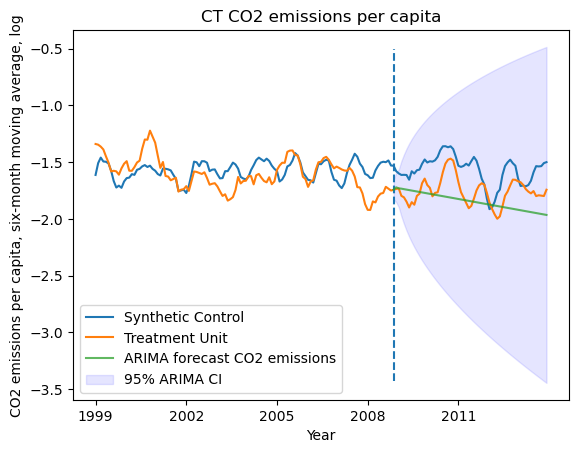

CT test RMSE: 0.113


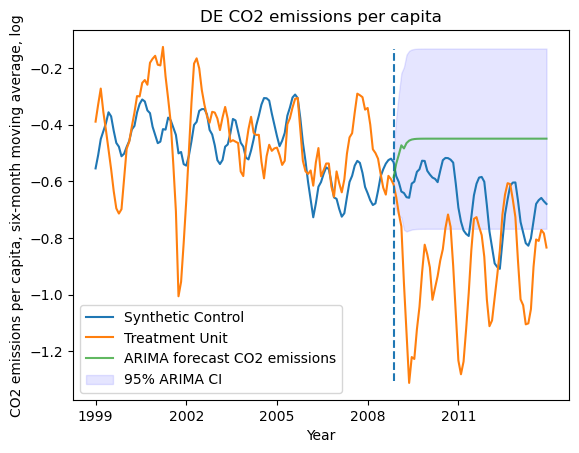

DE test RMSE: 1.377


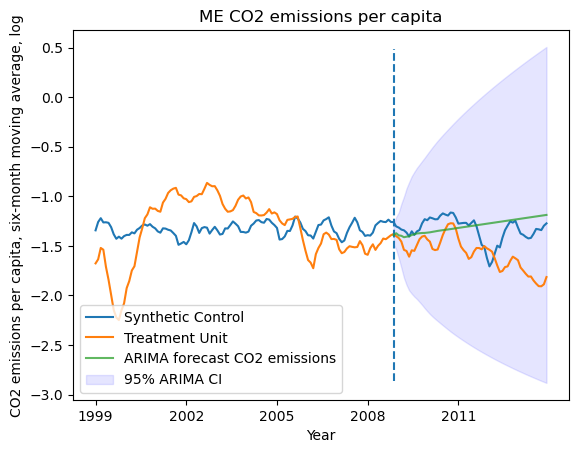

ME test RMSE: 0.551


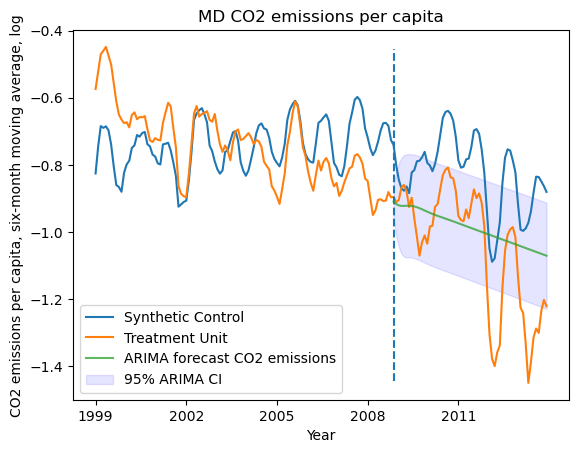

MD test RMSE: 0.846


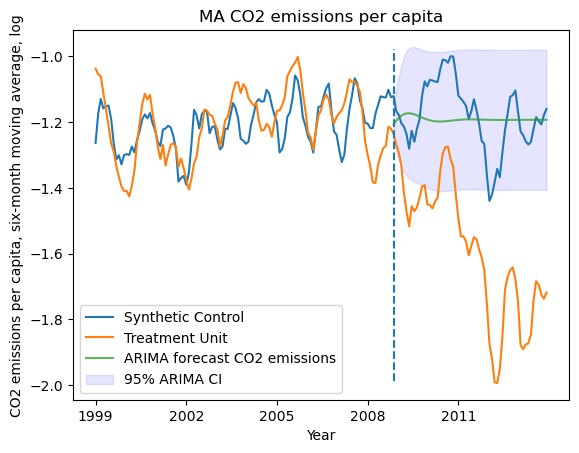

MA test RMSE: 0.647


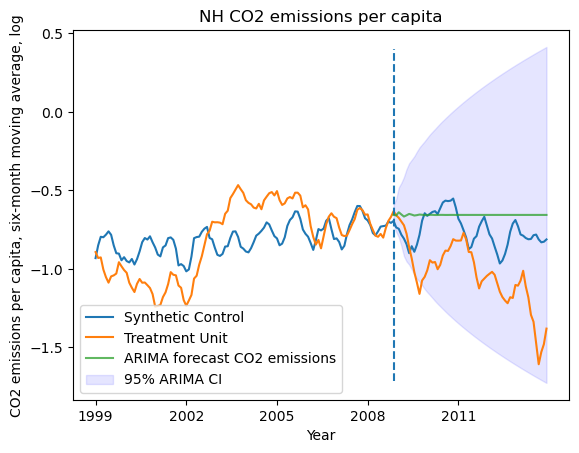

NH test RMSE: 1.177


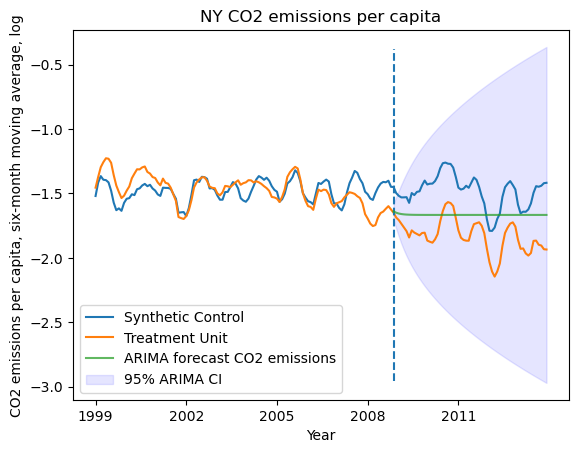

NY test RMSE: 0.203


In [ ]:
treatment_time = '2009-01-01'
for state in rggi_states:
    # Get treatment range, predictions for each state, and confidence intervals for each state
    pred_state = arima_models[state][1]
    conf_int_state = arima_models[state][2]
    
    Z0,Z1=aug_synth_models[state][1].make_outcome_mats(time_period=years_sma)
    ts_synth=aug_synth_models[state][0]._synthetic(Z0)
    # Plot the forecasts
    plt.plot(ts_synth, label='Synthetic Control') 
    plt.plot(Z1, label='Treatment Unit')
    plt.axvline(x=treatment_time, ymin=0.05, ymax=0.95, linestyle="dashed") 
    plt.plot(treat_range, pred_state, alpha=0.75, label='ARIMA forecast CO2 emissions')
    plt.fill_between(treat_range,
                conf_int_state[:, 0], conf_int_state[:, 1],
                alpha=0.1, color='b', label='95% ARIMA CI')
    plt.title(f"{state} CO2 emissions per capita")
    plt.legend(loc='lower left')
    plt.ylabel("CO2 emissions per capita, six-month moving average, log")
    plt.xlabel("Year")
    years = pd.to_datetime(years_sma).year
    xticks = plt.gca().get_xticks()
    xticks = xticks[::int(len(xticks)/5)]0
    plt.xticks(xticks, [f'{years[i]}' for i in xticks])
    plt.show() 
    print(f"{state} test RMSE: %.3f" % np.sqrt(mean_squared_error(test['co2_per_capita_sma_log'],pred_state)))